In [2]:
# Estos dos comandos evitan que haya que hacer reload cada vez que se modifica un paquete
%load_ext autoreload
%autoreload 2

In [12]:
import numpy as np
from matplotlib import pyplot as plt

# Importo el paquete para graficar
from matplotlib import pyplot as plt

def plot_bar_chart(P, indexes=None, index_str='$P(S=%s)$' ,title='Función de masa de probabilidad de la posición del robot: $P(S=k)$'):
    N = len(P)
    if indexes is None:
        indexes = np.linspace(1, N, N, dtype = int) # Desde, Hasta, Cantidad, Tipo
    plt.figure(figsize=(20, 5)) # Tamaño del gráfico
    plt.bar(indexes, P, width=0.75, color='b') # Grafico
    plt.title(title)

    # Definición de indices
    string_indexes = [index_str%i for i in indexes]
    plt.xlim([0,N+1])
    plt.xticks(indexes, string_indexes) 
    plt.xticks(rotation=60)
    plt.show()

# Naive bayes
http://scikit-learn.org/stable/modules/naive_bayes.html#naive-bayes

$P(y|x_1,x_2,...,x_n) = \large \frac{P(y)P(x_1, x_2,...,x_n|y)}{P(x_1,x_2,...,x_n)} = \frac{P(y, x_1, x_2,...,x_n)}{P(x_1,x_2,...,x_n)}$

$P(x_1,x_2, x_3, y) = P(x_1 | x_2, x_3,y)P(x_2,x_3, y) = P(x_1 | x_2, x_3,y)P(x_2|x_3, y)P(x_3, y) = P(x_1 | x_2, x_3,y)P(x_2|x_3, y)P(x_3| y)P(y)$

$P(comprar,oferta,ganaste,SPAM) = P(comprar | oferta, ganaste,SPAM)P(oferta|ganaste, SPAM)P(ganaste| SPAM)P(SPAM)$

Asumiendo independencia

$P(x_i/y) = P(x_i|y,x_1,...)$

$P(comprar,oferta,ganaste,SPAM) = P(comprar | SPAM)P(oferta|SPAM)P(ganaste| SPAM)P(SPAM)$

$P(y|x_1,x_2,...,x_n) = \large \frac{P(y)\prod P(x_i/y)} {P(x_1,x_2,...,x_n)} = \alpha {P(y)\prod P(x_i/y)}$

$\hat{y} = arg max_y [{P(y)\prod P(x_i/y)}]$

## Detección de SPAM
V. Metsis, I. Androutsopoulos and G. Paliouras (2006). Spam filtering with Naive Bayes – Which Naive Bayes? 3rd Conf. on Email and Anti-Spam (CEAS).
http://citeseerx.ist.psu.edu/viewdoc/download;jsessionid=1EEA3C5EE5DDF8409BCC0F09BFB7D98B?doi=10.1.1.61.5542&rep=rep1&type=pdf

Tenemos un dataset donde ya esta preprocesado el texto
- Lemmatization
- Stop words

In [13]:
from sklearn.feature_extraction.text import CountVectorizer

In [14]:
import os
from collections import Counter
def make_Dictionary(train_dir):
    emails_array = []
    labels = []
    emails = [os.path.join(train_dir,f) for f in os.listdir(train_dir)]    
    all_words = []       
    for mail in emails:    
        with open(mail) as m:
            if 'spmsg' in mail.split('/')[-1]:
                labels.append(True)
            else:
                labels.append(False)
            email_str = ''
            for i,line in enumerate(m):
                if i == 2:  #Body of email is only 3rd line of text file
                    words = line.split()
                    all_words += words
                    email_str = email_str + ' ' + line
            emails_array.append(email_str)
    dictionary = Counter(all_words)
    # Paste code for non-word removal here(code snippet is given below) 
    return dictionary, emails_array, labels

def remove_uncommon_words(dictionary):
    dict_copy = { k : v for k,v in dictionary.items()}
    list_to_remove = dictionary.keys()

    for item in list_to_remove:
        if item.isalpha() == False: 
            del dict_copy[item]
        elif len(item) == 1:
            del dict_copy[item]
    return Counter(dict_copy)

In [15]:
def read_emails_and_get_dict(folder, max_features=3000):
    dictionary, emails_array, labels = make_Dictionary(folder)
    dictionary = remove_uncommon_words(dictionary)
    dictionary = dictionary.most_common(max_features)
    vocabulary = [key[0] for key in dictionary]
    return vocabulary, emails_array, np.array(labels)

In [16]:
max_features = 3000

In [17]:
vocabulary, emails_array, labels = read_emails_and_get_dict('./ling-spam/train-mails', max_features)
count_vectorizer = CountVectorizer(vocabulary=vocabulary)
feature_matrix = count_vectorizer.fit_transform(emails_array)

In [18]:
def get_histogram_from_matrix(alpha, feature_matrix):
    words_distribution_un = feature_matrix.sum(axis=0) + alpha
    words_distribution = words_distribution_un/(words_distribution_un.sum()+alpha*feature_matrix.shape[1])
    return words_distribution

spam_feature_matrix = feature_matrix[labels,:]
ham_feature_matrix = feature_matrix[np.logical_not(labels),:]

print('SPAM:',labels.nonzero()[0].shape[0],
      'HAM:',np.logical_not(labels).nonzero()[0].shape[0],
      'total:',len(labels))

print()
print('Palabras diferentes')
print('SPAM:', spam_feature_matrix.nonzero()[0].shape[0],
      'HAM:',ham_feature_matrix.nonzero()[0].shape[0])

print()
print('Cantidad de palabras')
print('SPAM:',spam_feature_matrix.sum(), 'HAM:',ham_feature_matrix.sum())



spam_words_distribution = get_histogram_from_matrix(1, spam_feature_matrix)
ham_words_distribution = get_histogram_from_matrix(1, ham_feature_matrix)

SPAM: 351 HAM: 351 total: 702

Palabras diferentes
SPAM: 49238 HAM: 33252

Cantidad de palabras
SPAM: 98131 HAM: 56860


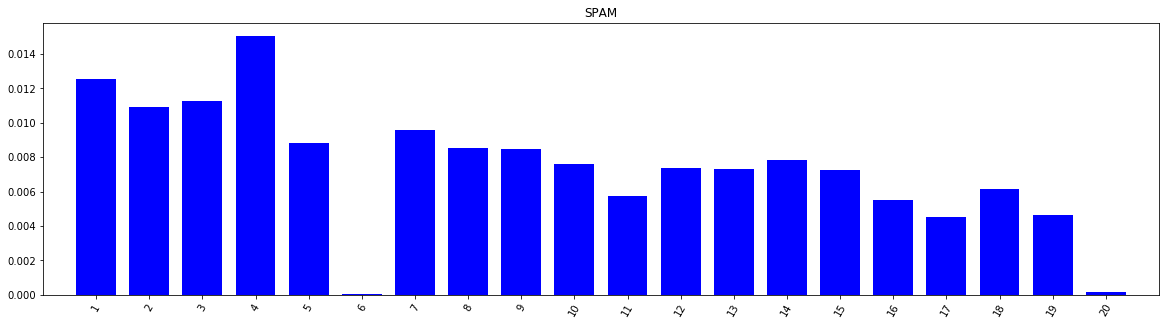

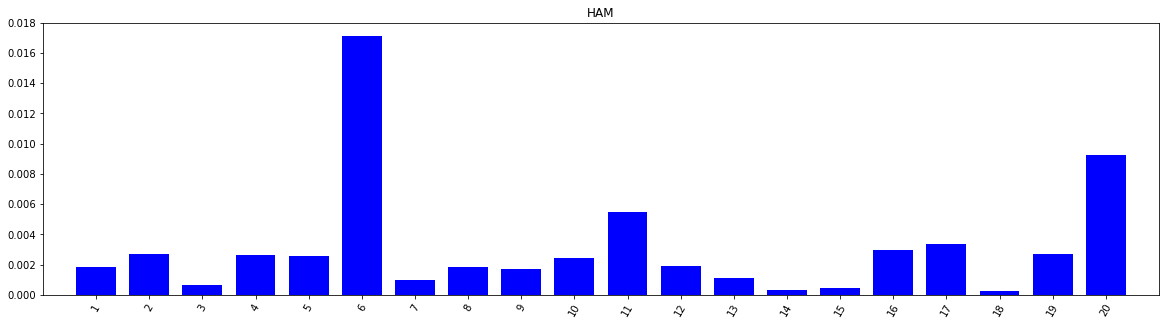

In [19]:
N = 20
plot_bar_chart(np.array(spam_words_distribution)[0][:N], title='SPAM', index_str='%s')
plot_bar_chart(np.array(ham_words_distribution)[0][:N], title='HAM', index_str='%s')

$\hat{y} = arg max_y [{P(y)\prod P(x_i/y)}]$

$y = [SPAM, HAM]$

In [20]:
row = feature_matrix[0,:]
print(row)
non_zero_row = row.nonzero()
print(non_zero_row)
print(spam_words_distribution[0, non_zero_row].prod())
print(ham_words_distribution[0, non_zero_row].prod())
print(np.log(spam_words_distribution[0, non_zero_row]).sum())
print(np.log(ham_words_distribution[0, non_zero_row]).sum())

  (0, 5)	1
  (0, 9)	1
  (0, 11)	4
  (0, 22)	1
  (0, 37)	1
  (0, 42)	1
  (0, 47)	1
  (0, 51)	1
  (0, 59)	1
  (0, 116)	1
  (0, 118)	1
  (0, 140)	1
  (0, 143)	1
  (0, 209)	1
  (0, 260)	1
  (0, 274)	1
  (0, 291)	1
  (0, 299)	1
  (0, 318)	3
  (0, 337)	1
  (0, 380)	1
  (0, 384)	1
  (0, 436)	1
  (0, 461)	1
  (0, 471)	2
  (0, 481)	3
  (0, 611)	1
  (0, 651)	2
  (0, 699)	1
  (0, 704)	1
  (0, 934)	1
  (0, 954)	1
  (0, 955)	2
  (0, 979)	1
  (0, 1037)	1
  (0, 1047)	1
  (0, 1233)	2
  (0, 1499)	1
  (0, 1575)	1
  (0, 1645)	1
  (0, 1684)	1
  (0, 1750)	1
  (0, 2116)	1
  (0, 2271)	1
  (0, 2456)	1
  (0, 2816)	3
(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32), array([   5,    9,   11,   22,   37,   42,   47,   51,   59,  116,  118,
        140,  143,  209,  260,  274,  291,  299,  318,  337,  380,  384,
        436,  461,  471,  481,  611,  651,  699,  704,  934,  954,  955,
        979, 1

In [21]:
def get_accuracy(feature_matrix, labels, spam_words_distribution, ham_words_distribution):
    P_SPAM = labels.nonzero()[0].shape[0]/len(labels) # Por que no es necesario en este caso?
    P_HAM = np.logical_not(labels).nonzero()[0].shape[0]/len(labels) # Por que no es necesario en este caso?
    correct_count = 0
    smooth = 0.0000000000001
    for i, row in enumerate(feature_matrix):
        coded_email = row.nonzero()
        spam_log_likelihood = np.log(spam_words_distribution[coded_email]).sum() + np.log(P_SPAM)
        ham_log_likelihood = np.log(ham_words_distribution[coded_email]).sum() + np.log(P_HAM)
        SPAM = spam_log_likelihood>ham_log_likelihood
        if SPAM == labels[i]:
            correct_count = correct_count + 1
    print('%0.3f'%(correct_count/len(labels)))

In [22]:
get_accuracy(feature_matrix, labels, spam_words_distribution, ham_words_distribution)

0.989


## Test set

In [23]:
_, emails_array, labels_test = read_emails_and_get_dict('./ling-spam/test-mails', max_features)
count_vectorizer_test = CountVectorizer(vocabulary=vocabulary)
feature_matrix_test = count_vectorizer.fit_transform(emails_array)

In [24]:
get_accuracy(feature_matrix_test, labels_test, spam_words_distribution, ham_words_distribution)

0.965


# sklearn

In [25]:
from sklearn.naive_bayes import MultinomialNB

In [26]:
clf = MultinomialNB(alpha=1)

In [27]:
clf.fit(feature_matrix, labels)

MultinomialNB(alpha=1, class_prior=None, fit_prior=True)

In [28]:
clf.score(feature_matrix, labels)

0.99002849002849003

In [29]:
clf.score(feature_matrix_test, labels_test)

0.96153846153846156

# ¿Es posible graficar un problema de dimensión 3000 en 2 dimensiones?

In [30]:
from sklearn.manifold import TSNE
from sklearn.decomposition import TruncatedSVD
fmd = feature_matrix.todense()
svd = TruncatedSVD(n_components=8, n_iter=200, random_state=42)
svd.fit(fmd.T)
X_embedded = TSNE(n_components=2).fit_transform(svd.components_.T)

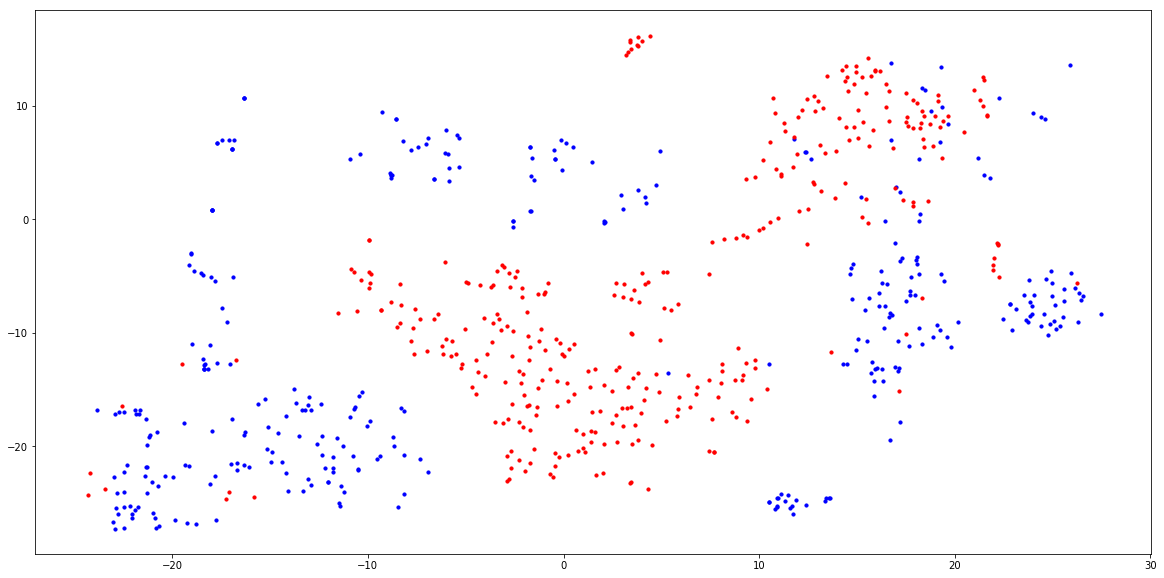

In [31]:
plt.figure(figsize=(20,10))
plt.scatter(X_embedded[labels,0], X_embedded[labels,1], color='b', s=10)
plt.scatter(X_embedded[np.logical_not(labels),0], X_embedded[np.logical_not(labels),1], color='r', s=10)
plt.show()

# Gaussian NB
https://en.wikipedia.org/wiki/Naive_Bayes_classifier#Sex_classification

In [32]:
# Datos originales de wikipedia
data = [
    {"genero":'hombre', 'altura': 6, 'peso': 180,'pie':12}, 
    {"genero":'hombre', 'altura': 5.92, 'peso': 190,'pie':11}, 
    {"genero":'hombre', 'altura': 5.58, 'peso': 170,'pie':12}, 
    {"genero":'hombre', 'altura': 5.92, 'peso': 165,'pie':10}, 
    {"genero":'mujer', 'altura': 5, 'peso': 100,'pie':6}, 
    {"genero":'mujer', 'altura': 5.5, 'peso': 150,'pie':8}, 
    {"genero":'mujer', 'altura': 5.42, 'peso': 130,'pie':7}, 
    {"genero":'mujer', 'altura': 5.75, 'peso': 150,'pie':9}, 
]

In [33]:
data = [{'altura': 183, 'genero': 'hombre', 'peso': 82, 'pie': 12},
         {'altura': 180, 'genero': 'hombre', 'peso': 86, 'pie': 11},
         {'altura': 170,'genero': 'hombre','peso': 77,'pie': 12},
         {'altura': 180, 'genero': 'hombre', 'peso': 75, 'pie': 10},
         {'altura': 152, 'genero': 'mujer', 'peso': 45, 'pie': 6},
         {'altura': 167, 'genero': 'mujer', 'peso': 68, 'pie': 8},
         {'altura': 165, 'genero': 'mujer', 'peso': 59, 'pie': 7},
         {'altura': 175, 'genero': 'mujer', 'peso': 68, 'pie': 9}]

In [34]:
GNB_features_matrix = np.zeros((len(data),3))
GNB_labels = np.empty((len(data)), dtype=object)
print(GNB_features_matrix)
print(GNB_labels)

for i, person in enumerate(data):
    GNB_features_matrix[i, 0] = person['altura']
    GNB_features_matrix[i, 1] = person['peso']
    GNB_features_matrix[i, 2] = person['pie']
    GNB_labels[i] = person['genero']
print(GNB_features_matrix)
print(GNB_labels)

[[ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]]
[None None None None None None None None]
[[ 183.   82.   12.]
 [ 180.   86.   11.]
 [ 170.   77.   12.]
 [ 180.   75.   10.]
 [ 152.   45.    6.]
 [ 167.   68.    8.]
 [ 165.   59.    7.]
 [ 175.   68.    9.]]
['hombre' 'hombre' 'hombre' 'hombre' 'mujer' 'mujer' 'mujer' 'mujer']


In [35]:
men_means = GNB_features_matrix[GNB_labels=='hombre',:].mean(axis=0)
women_means = GNB_features_matrix[GNB_labels=='mujer',:].mean(axis=0)
men_vars = GNB_features_matrix[GNB_labels=='hombre',:].var(axis=0, ddof=1)
women_vars = GNB_features_matrix[GNB_labels=='mujer',:].var(axis=0, ddof=1)
print('medias de los hombres:', men_means)
print('varianzas de los hombres:', men_vars)
print('medias de las mujeres:', women_means)
print('varianzas de las mujeres:', women_vars)

medias de los hombres: [ 178.25   80.     11.25]
varianzas de los hombres: [ 32.25        24.66666667   0.91666667]
medias de las mujeres: [ 164.75   60.      7.5 ]
varianzas de las mujeres: [  90.91666667  118.            1.66666667]


In [36]:
#sample = np.array([6,130,8])
sample = np.array([6*30.48,130*0.453592,8])

In [37]:
def gaussian(x, mu, sig):
    return np.exp(-np.power((x - mu)/sig, 2.)/2)/(np.sqrt(2.*np.pi)*sig)

def plot_gaussian(mu=0, sig= 1, points = 200, N = 2, marker=None, label = None, x = None, color = None, 
                  x_label='',y_label='',ax = None, figsize = (20,10), center_label_tick = None):
    if ax is None:
        f, ax = plt.subplots(1, 1, sharey=True, sharex=True, figsize = figsize)
    if x is None:
        x = np.linspace(mu-N*sig, mu+N*sig, points)
    y = gaussian(x, mu, sig)
    ax.plot(x,y, marker = marker, label = label, color = color)
    ax.set_ylabel(y_label)
    ax.set_xlabel(x_label)

    if center_label_tick is not None:
        labels = [item.get_text() for item in ax.get_xticklabels()]
        labels[int((len(labels)-1)/2)] = center_label_tick
        ax.set_xticklabels(labels)

    return x, y

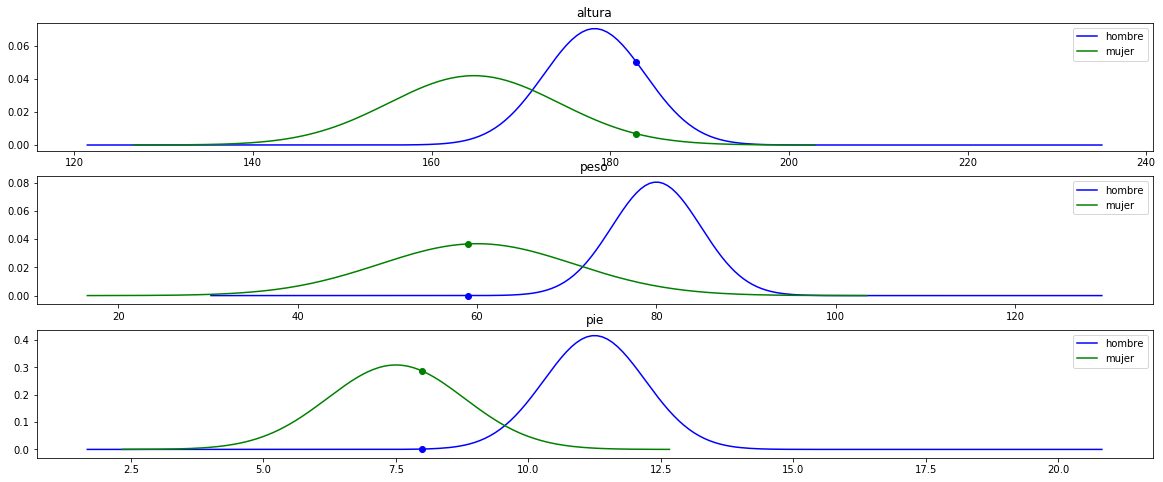

In [38]:
f, axs = plt.subplots(3, 1, sharey=False, sharex=False, figsize = (20,8))
keys = ['altura', 'peso','pie']
for i, ax in enumerate(axs):
    plot_gaussian(men_means[i], np.sqrt(men_vars[i]), ax=ax, N=10, color='b', label='hombre')
    plot_gaussian(women_means[i], np.sqrt(women_vars[i]), ax=ax, N=4, color='g', label='mujer')
    ax.scatter(sample[i], gaussian(sample[i], men_means[i], np.sqrt(men_vars[i])), color='b')
    ax.scatter(sample[i], gaussian(sample[i], women_means[i], np.sqrt(women_vars[i])), color='g')
    ax.title.set_text(keys[i])
    ax.legend()
plt.show()

In [39]:
p_hombre = len(GNB_features_matrix[GNB_labels=='hombre',:])/len(GNB_features_matrix)
p_altura_hombre = gaussian(sample[0], men_means[0], np.sqrt(men_vars[0]))
p_peso_hombre = gaussian(sample[1], men_means[1], np.sqrt(men_vars[1]))
p_pie_hombre = gaussian(sample[2], men_means[2], np.sqrt(men_vars[2]))
posterior_hombre = p_hombre*p_altura_hombre*p_peso_hombre*p_pie_hombre
print(posterior_hombre)

3.38329394047e-10


In [40]:
p_mujer = len(GNB_features_matrix[GNB_labels=='hombre',:])/len(GNB_features_matrix)
p_altura_mujer = gaussian(sample[0], women_means[0], np.sqrt(women_vars[0]))
p_peso_mujer = gaussian(sample[1], women_means[1], np.sqrt(women_vars[1]))
p_pie_mujer = gaussian(sample[2], women_means[2], np.sqrt(women_vars[2]))
posterior_mujer = p_mujer*p_altura_mujer*p_peso_mujer*p_pie_mujer
print(posterior_mujer)

3.59675362977e-05


In [41]:
posterior_mujer>posterior_hombre

True

Notar que no hace falta calcular el denominador

# Utilizando sklearn

In [42]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
y_pred = gnb.fit(GNB_features_matrix, GNB_labels)

In [43]:
y_pred.predict([sample])

array(['mujer'], 
      dtype='<U6')

In [44]:
y_pred.predict_proba([sample])

array([[  1.16498139e-07,   9.99999884e-01]])